In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd

import cartopy.crs as ccrs
import cartopy.feature as cf
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmocean

In [2]:
import graphufs

plt.style.use("graphufs.plotstyle")

/contrib2/Tim.Smith/graph-ufs/graphufs/training.py:59: UserWarning: Import failed for either mpi4py or mpi4jax.
  warnings.warn("Import failed for either mpi4py or mpi4jax.")


In [3]:
def swap_dims(xds):

    if "prediction_timedelta" in xds.coords and "lead_time" not in xds.coords:
        xds = xds.rename({"prediction_timedelta": "lead_time"})
    
    xds["fhr"] = (xds.lead_time.astype(int) / 3600 / 1e9).astype(int)
    xds = xds.swap_dims({"lead_time": "fhr"})
    return xds

In [4]:
def open_dataset(*args, **kwargs):
    xds = xr.open_dataset(*args, **kwargs)
    xds = swap_dims(xds)
    return xds

In [5]:
def open_zarr(*args, **kwargs):
    xds = xr.open_zarr(*args, **kwargs)
    xds = swap_dims(xds)
    
    xds["valid_time"] = xds.time + xds.lead_time
    xds = xds.set_coords("valid_time")
    return xds

In [13]:
#gds = open_zarr("/testlfs/latent-size-test/evaluation/validation/graphufs.240h.zarr/")

gds = []
for latent_size in [64, 128, 256]:
    gds.append(
        open_zarr(
            f"/testlfs/latent-size-test-{latent_size:03d}/evaluation/validation/graphufs.240h.zarr/"
        ).expand_dims({
            "latent_size": [latent_size],
        })
    )
gds = xr.concat(gds, dim="latent_size")
#gds = open_zarr("/p1-evaluation/gdm-v1/validation/graphufs_gdm.240h.zarr/")
#gds = open_zarr("/p1-evaluation/v1/validation/graphufs.240h.zarr/")

In [17]:
errors = []
for latent_size in [64, 128, 256]:
    errors.append(
        open_dataset(
            f"/testlfs/latent-size-test-{latent_size:03d}/evaluation/validation/graphufs_vs_replay_240h_deterministic_spatial.nc"
        ).expand_dims({
            "latent_size": [latent_size],
        })
    )
errors = xr.concat(errors, dim="latent_size")

In [7]:
era = xr.open_zarr(
    "gs://weatherbench2/datasets/era5/1959-2023_01_10-full_37-1h-0p25deg-chunk-1.zarr",
    storage_options={"token": "anon"},
)
era = era.sel(
    time=slice(
        gds.time.isel(time=0).values,
        gds.valid_time.isel(time=-1, fhr=-1).values
    ),
    level=[100,500,850],
)

In [8]:
from graphufs.spatialmap import SpatialMap

In [9]:
mapper = SpatialMap()

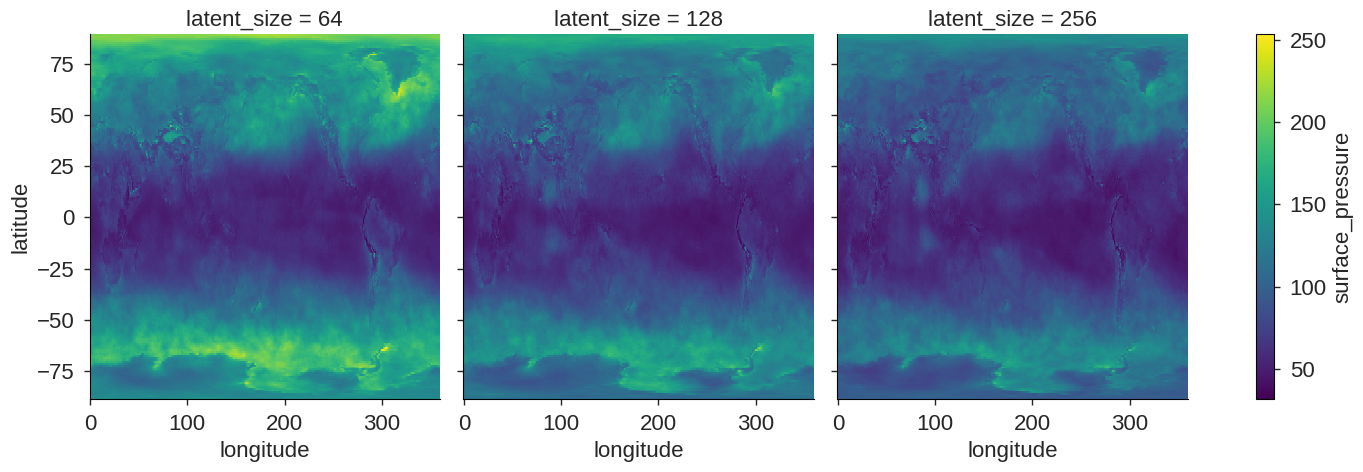

In [36]:
errors.surface_pressure.sel(
    metric="mae",
    fhr=24,
).plot(
    col="latent_size",
    figsize=(15,5),
)

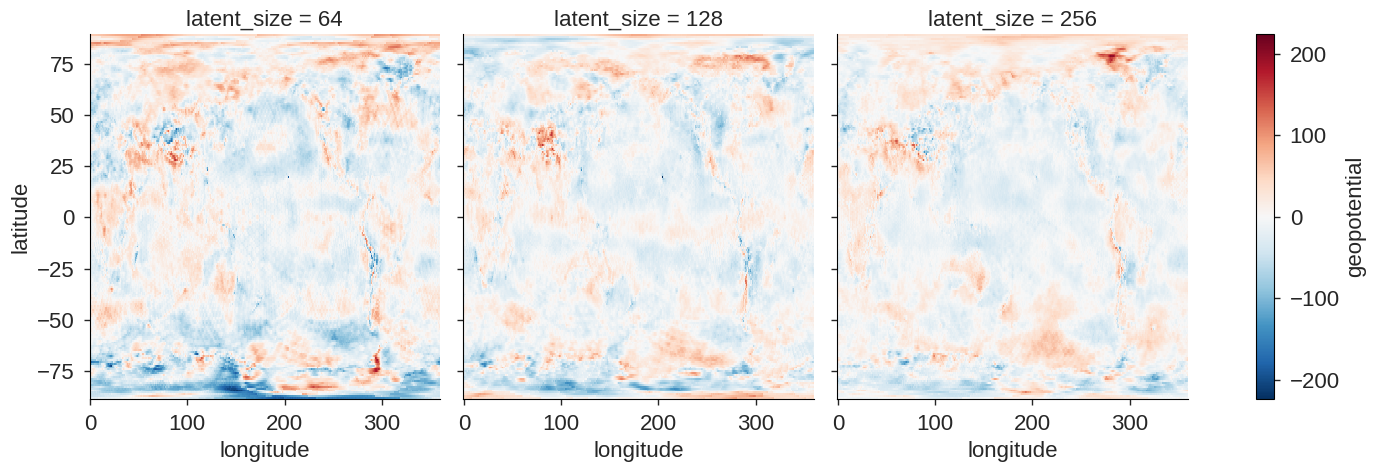

In [38]:
errors.geopotential.sel(
    level=500,
    method="nearest",
).sel(
    metric="bias",
    fhr=24,
).plot(
    col="latent_size",
    figsize=(15,5),
)

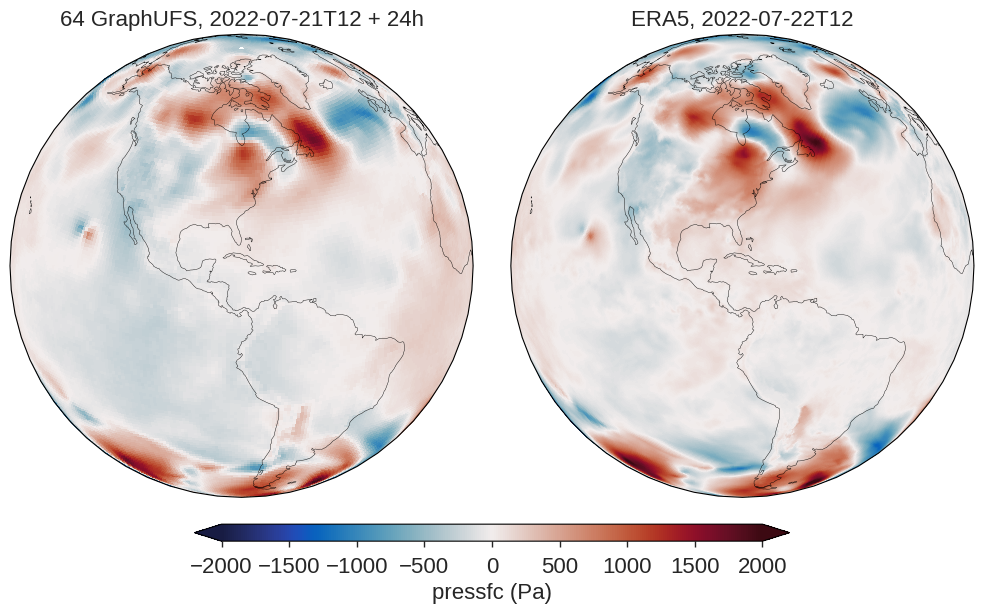

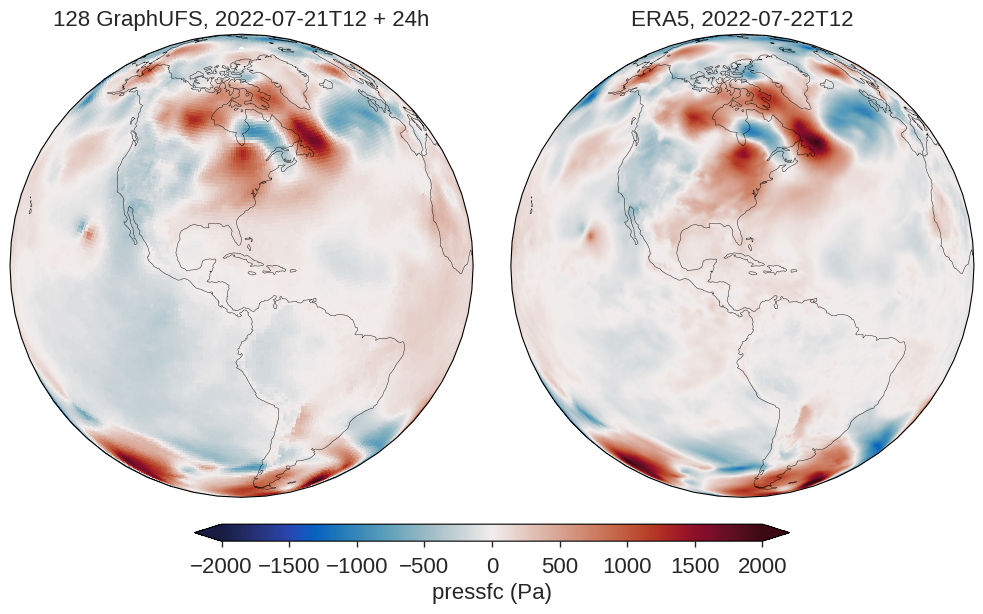

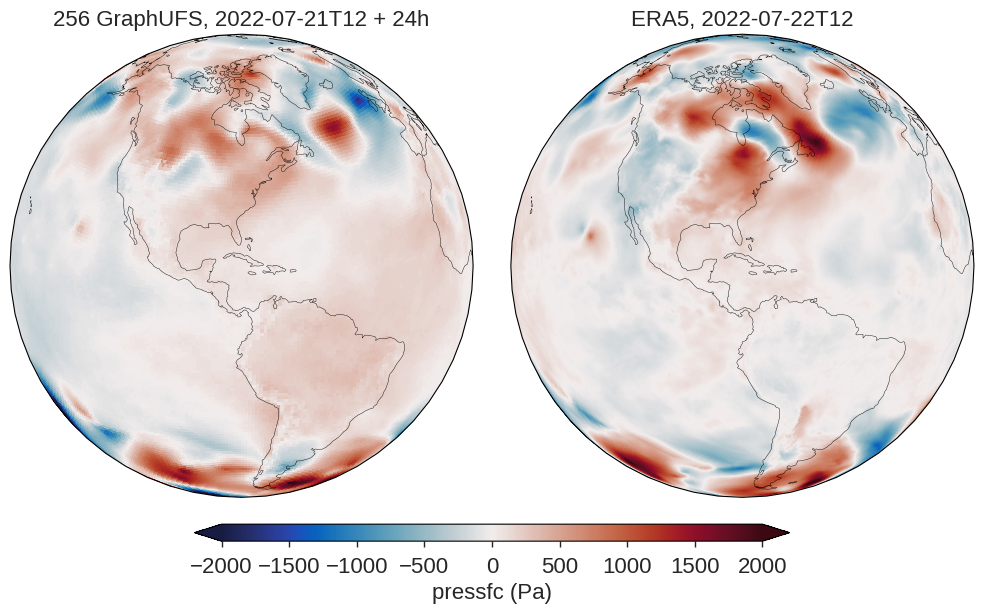

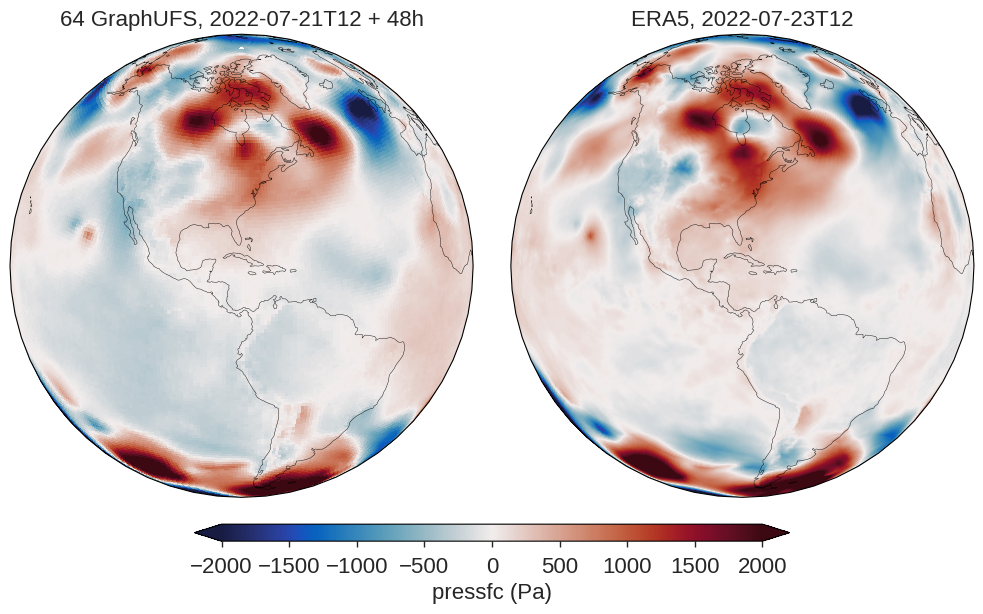

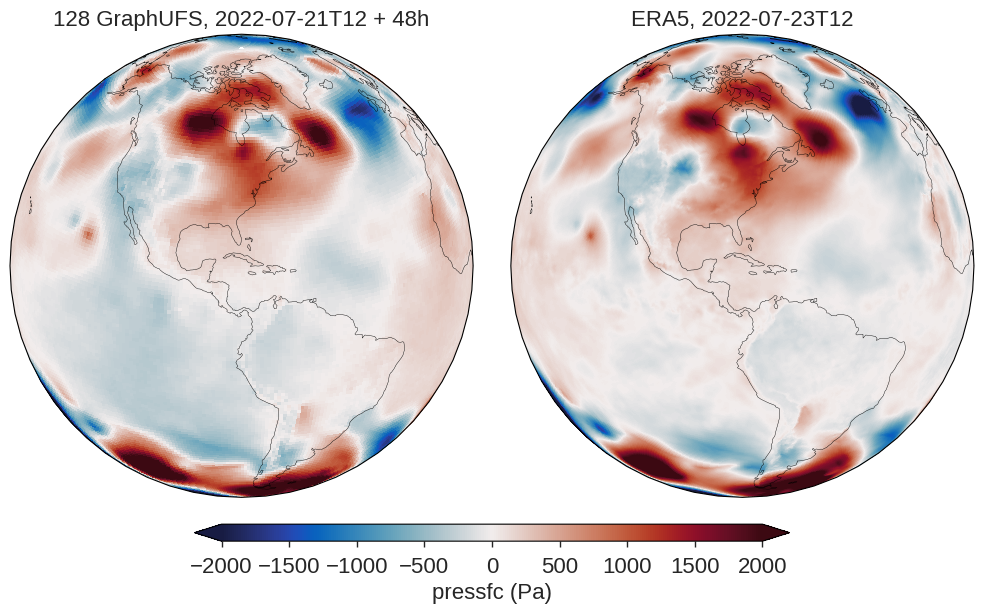

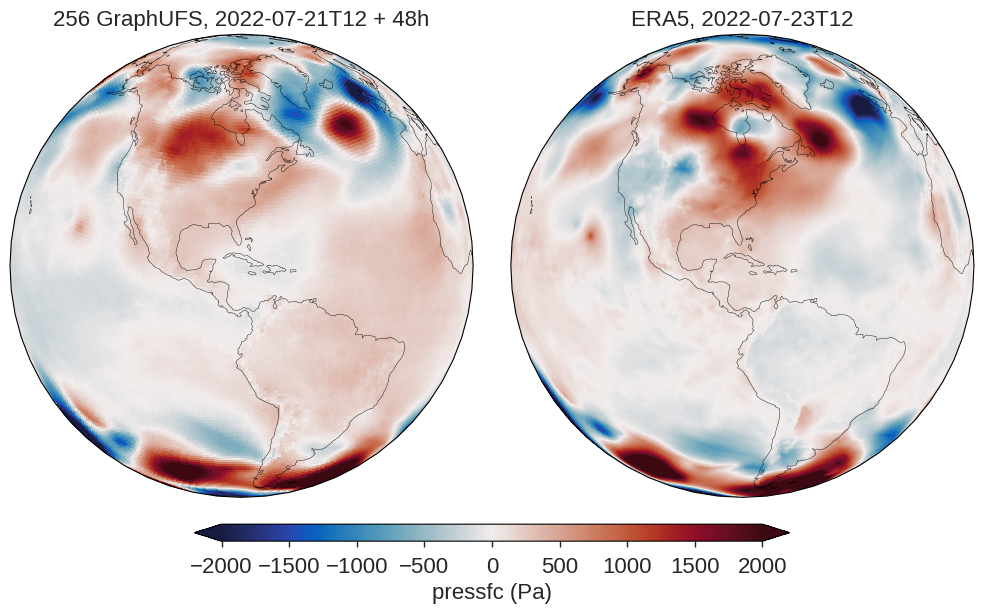

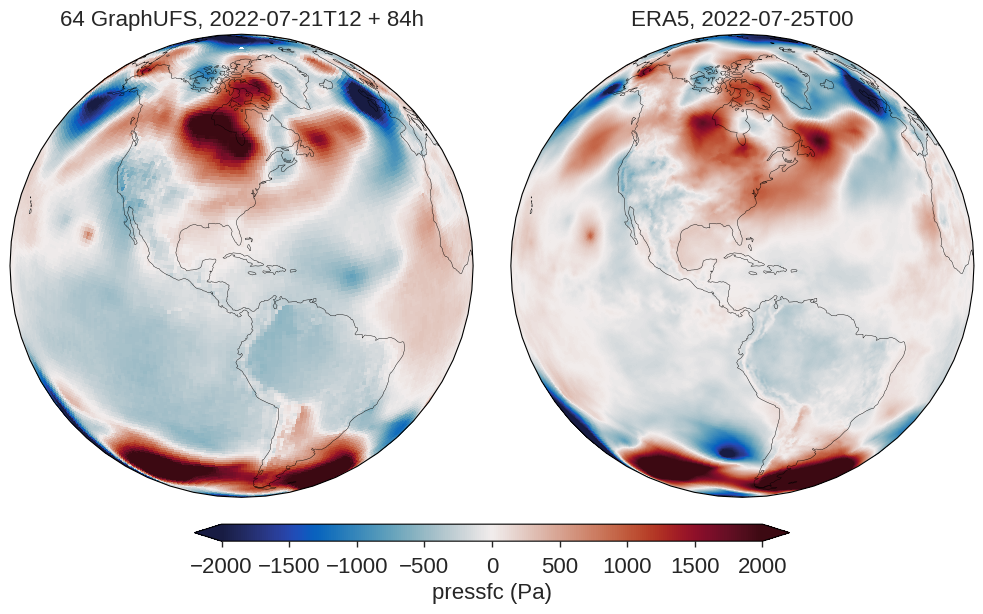

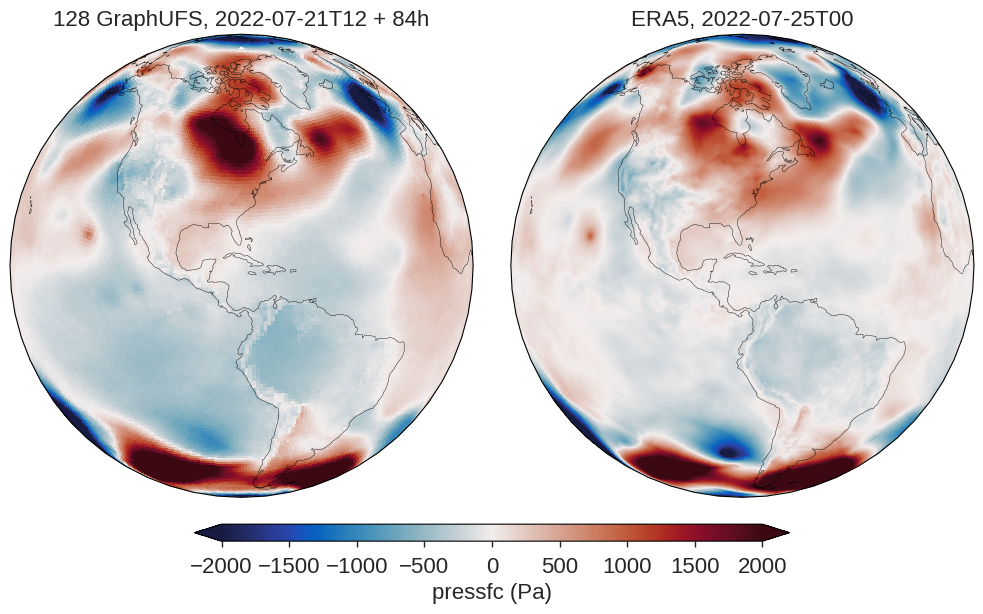

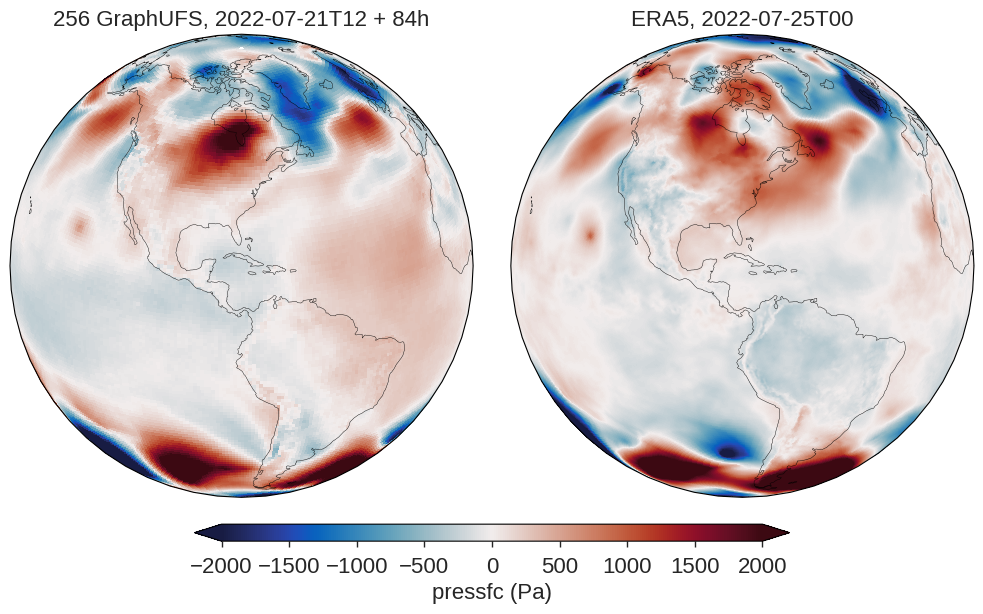

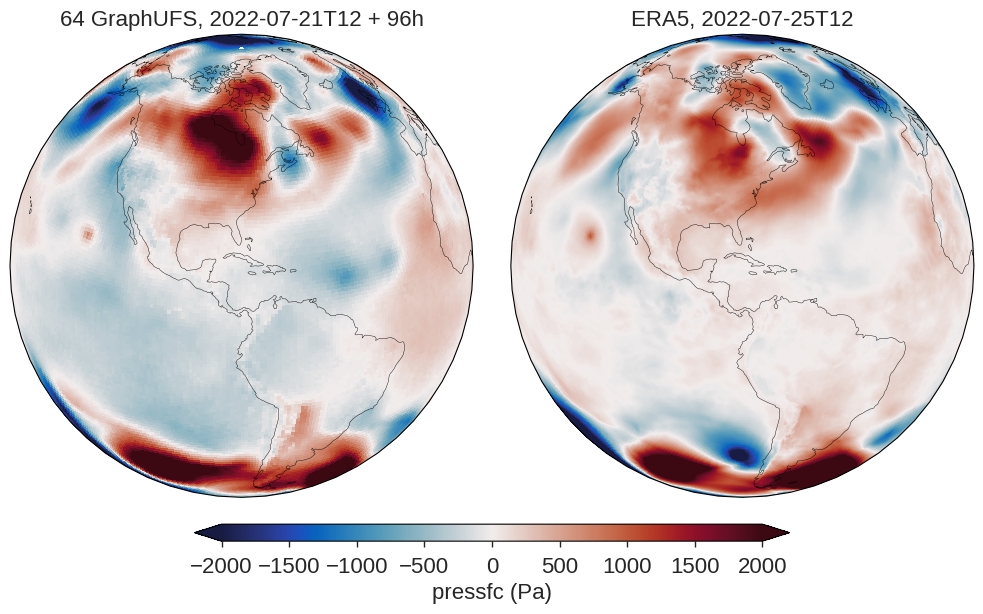

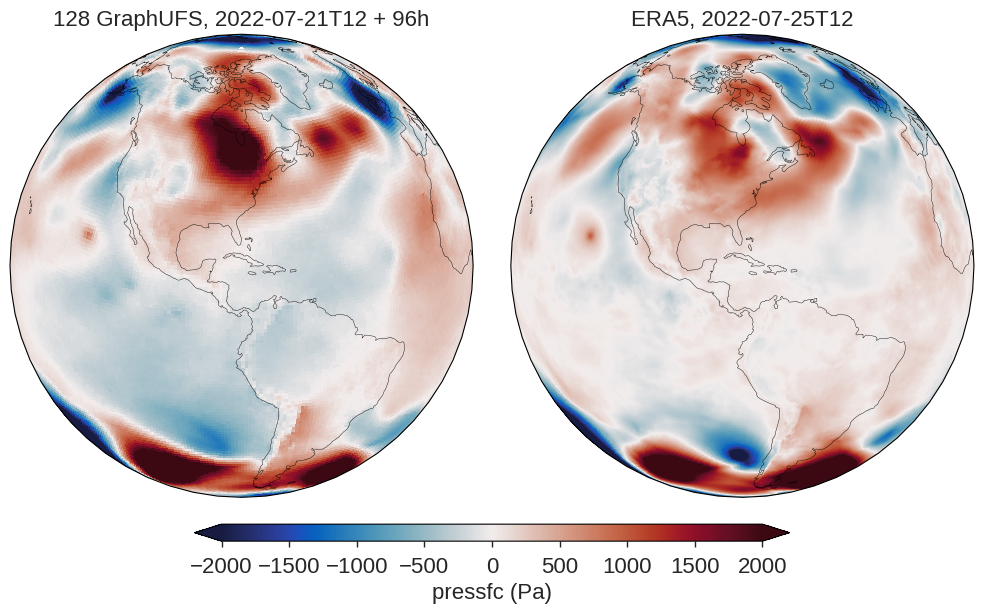

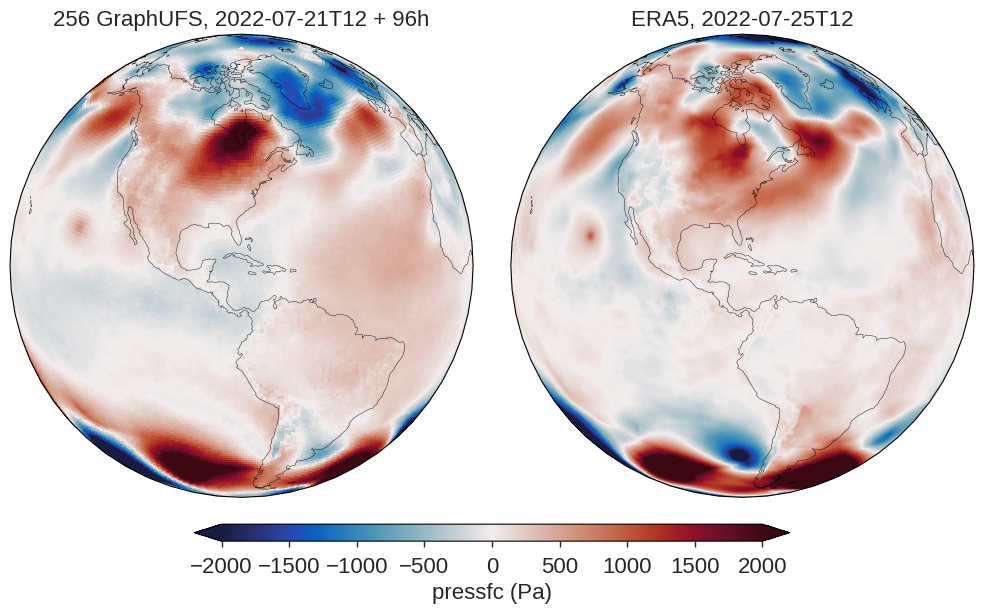

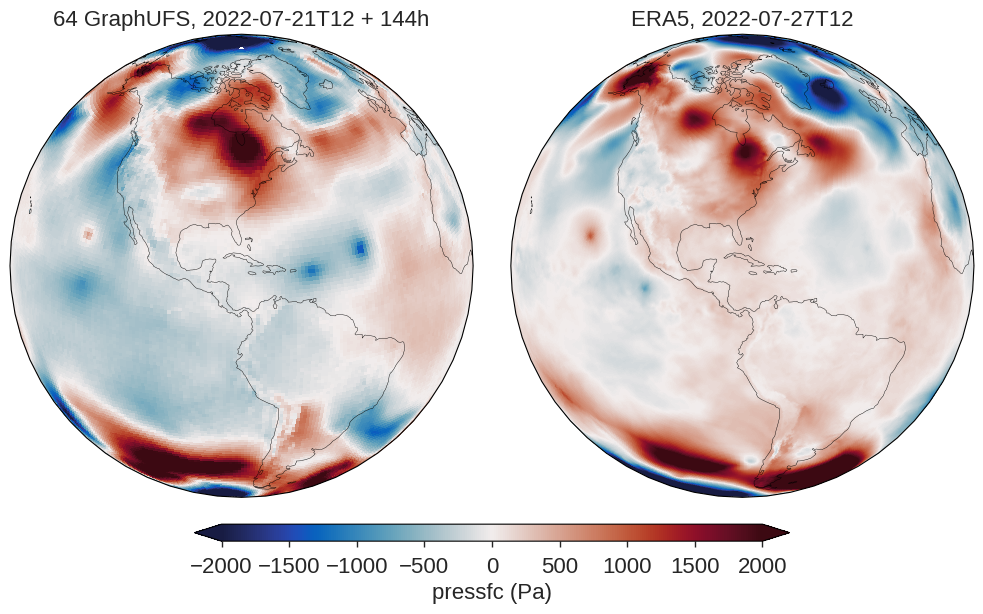

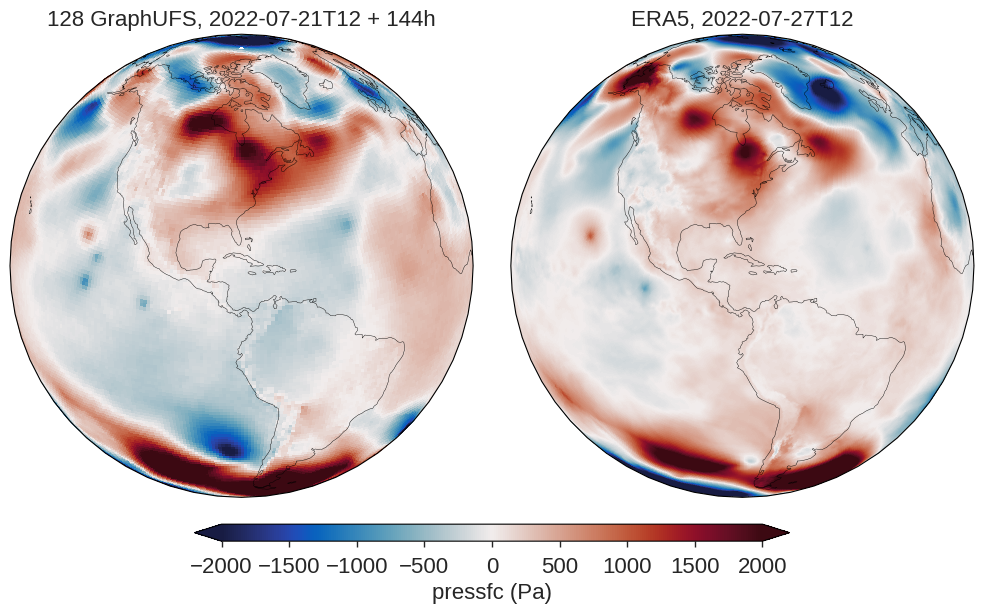

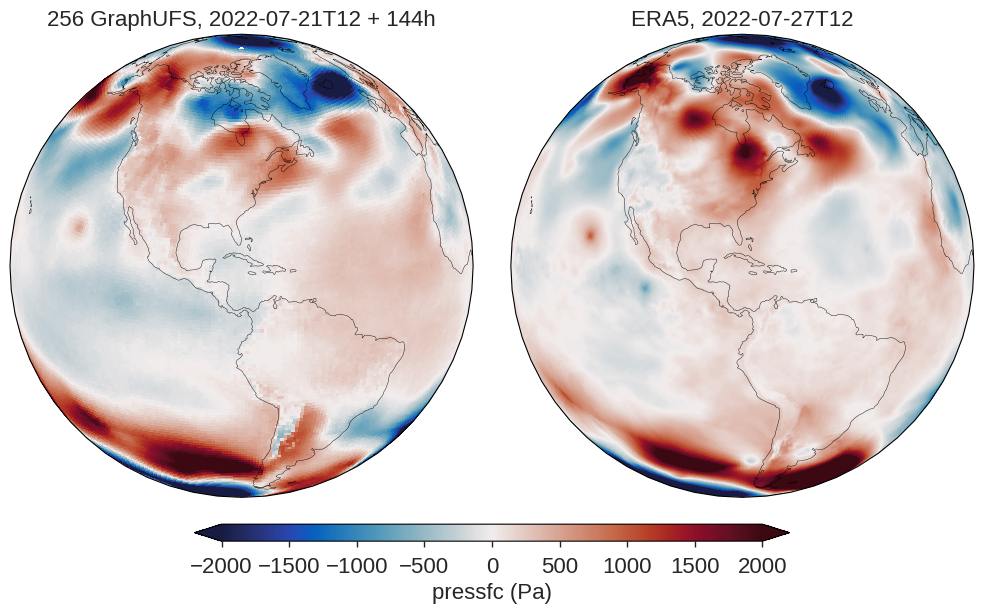

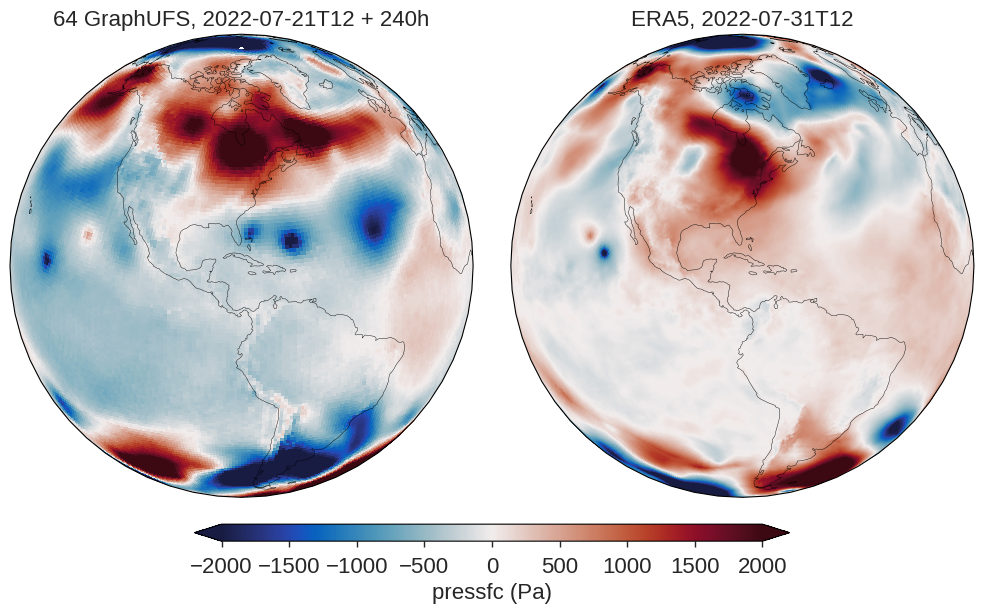

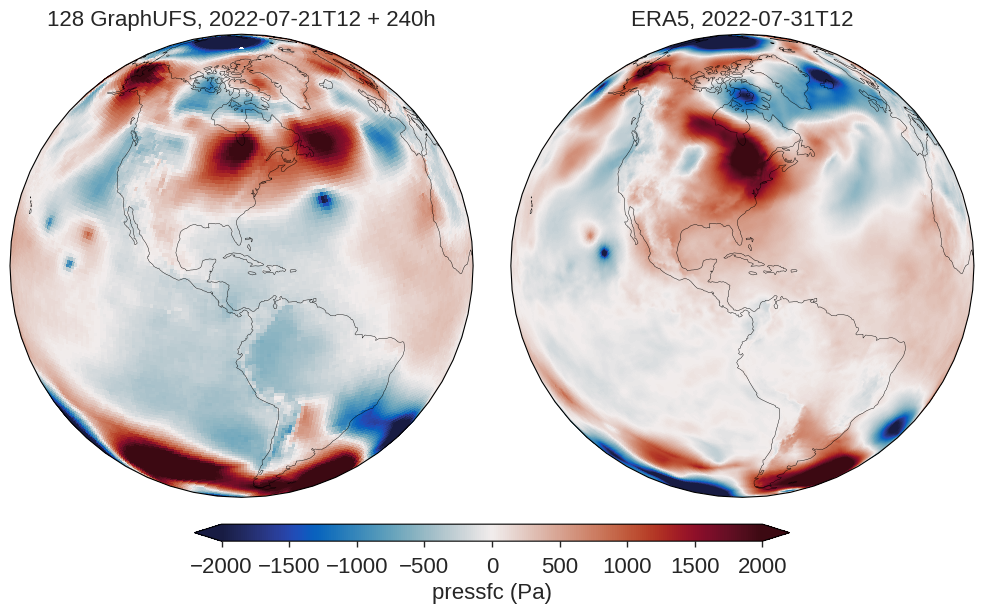

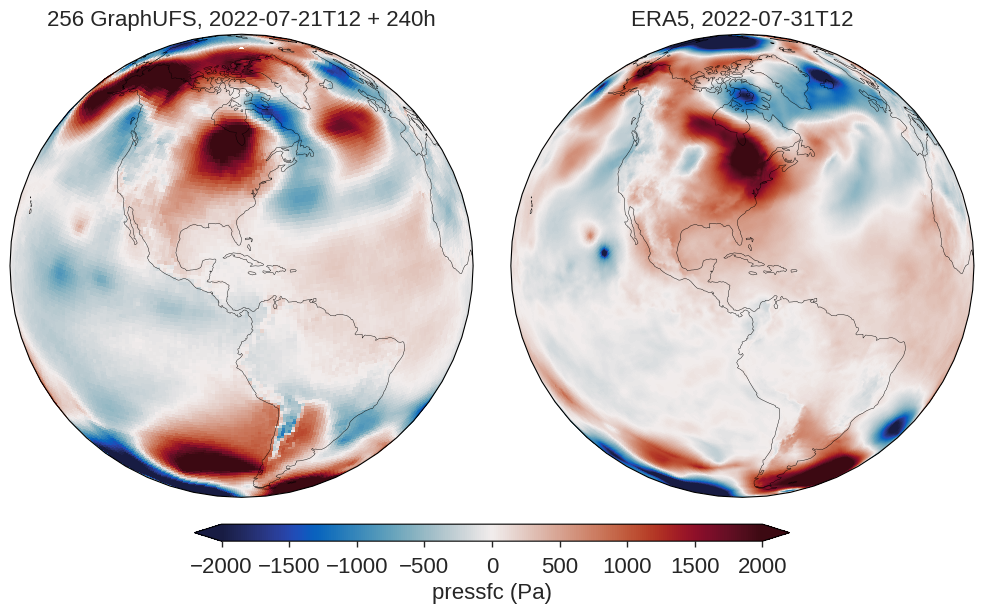

In [16]:
date = "2022-07-21T12"
gkey = "pressfc"
ekey = "surface_pressure"
kw = {
    "cmap": "cmo.balance",
    "vmin": -2000,
    "vmax": 2000
}

#gkey = "geopotential"
#ekey = gkey
#kw = {
#    "cmap": "cmo.balance",
#    "vmin": -2000,
#    "vmax": 2000
#}
#level = 1000


#gkey = "ugrd10m"
#ekey = "10m_u_component_of_wind"
#kw = {"cmap": "cmo.balance", "vmin": -20, "vmax": 20}

for fhr in [24, 24*2, 24*3 + 12, 24 * 4, 24 * 6, 24 * 10]:
    for latent_size in gds.latent_size.values:
        
        plotme = gds[gkey].sel(time=date, fhr=fhr, latent_size=latent_size)
        plotme -= gds[gkey].sel(time=plotme.time.values).isel(fhr=0).sel(latent_size=latent_size)
        if "level" in plotme.dims:
            plotme = plotme.sel(level=level, method="nearest")

        eplotme = era[ekey].sel(time=[plotme.valid_time.values])
        eplotme -= era[ekey].sel(time=date)
        if "level" in eplotme.dims:
            eplotme = eplotme.sel(level=level, method="nearest")
        fig, axs = mapper.plot(
            plotme,
            eplotme,
            **kw
        )
        axs[0].set(title=f"{latent_size} "+axs[0].get_title())
        #fig.savefig(f"figures/graphufs_{label.lower()}_and_era5_{gkey}_{fhr}h.jpeg", bbox_inches="tight", dpi=300)

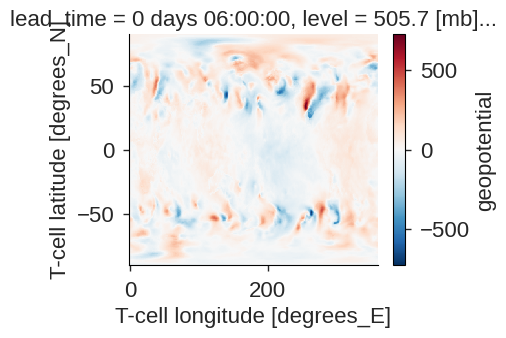

In [39]:
gds["geopotential"].sel(level=500, method="nearest").isel(time=0).diff("fhr").isel(fhr=0).plot()

In [ ]:
container = container.drop_vars("datetime")
container["datetime"] = xr.DataArray(
    [template["datetime"].isel(time=0) + pd.Timedelta(hours=t)
     for t in np.arange(18, fhr_long+12, 6)],
    dims=("batch", "time"),
)